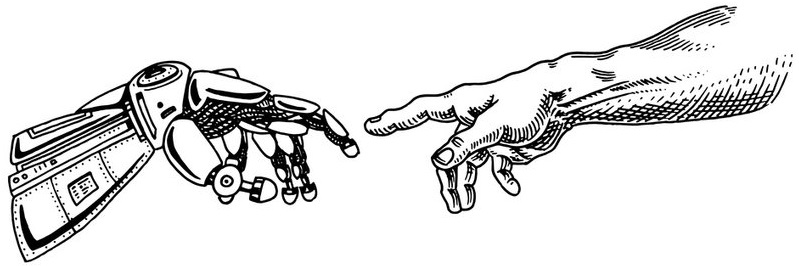

## Imports

In [2687]:
import numpy as np
import pandas as pd
import os
import time
import sys
import glob
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

## Load the data

#### Each file from (Sync, Alone, Spontan) is separated into a data frame so we can research and prepare it for model implementation

In [2688]:
Sync = []
Spontan = []
Alone = []
loc = r'D:\T'
def Makedf(location):
    for cs in os.listdir(location):
        if cs.endswith('Sync.csv'):
            Sync.append(os.path.join(r'D:\T', cs))
        elif cs.endswith('Alone.csv'):
            Alone.append(os.path.join(r'D:\T', cs))
        elif cs.endswith('Spontan.csv'):
            Spontan.append(os.path.join(r'D:\T', cs))
Makedf(loc)

Sync_T = []
Spontan_T = []
Alone_T = []
loc_T = r'D:\TEST'
def Makedftest(location):
    for cs in os.listdir(location):
        if cs.endswith('Sync.csv'):
            Sync_T.append(os.path.join(r'D:\TEST', cs))
        elif cs.endswith('Alone.csv'):
            Alone_T.append(os.path.join(r'D:\TEST', cs))
        elif cs.endswith('Spontan.csv'):
            Spontan_T.append(os.path.join(r'D:\TEST', cs))
Makedftest(loc_T)

In [2689]:
DF_Sync = pd.DataFrame()
for file in Sync:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Sync = pd.concat([DF_Sync,df], axis=0, ignore_index=True)
DF_Spot = pd.DataFrame()
for file in Spontan:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Spot = pd.concat([DF_Spot,df], axis=0, ignore_index=True)
DF_Alone = pd.DataFrame()
for file in Alone:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Alone = pd.concat([DF_Alone,df], axis=0, ignore_index=True)
DF_Sync_Test = pd.DataFrame()
for file in Sync_T:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Sync_Test = pd.concat([DF_Sync_Test,df], axis=0, ignore_index=True)
DF_Spot_Test = pd.DataFrame()
for file in Spontan_T:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Spot_Test = pd.concat([DF_Spot_Test,df], axis=0, ignore_index=True)
DF_Alone_Test = pd.DataFrame()
for file in Alone_T:
    df = pd.read_csv(file)
    RemoveSevenSecond(df)
    DF_Alone_Test = pd.concat([DF_Alone_Test,df], axis=0, ignore_index=True)

## Functions Area (Make the life more Simple)

* RemoveSevenSecond : take the data frame and delete the first seven seconds.


* RemoveHands : by given data frame and (value 2\1) the function delete all the value of hands (2\1).


* RemoveType : by given data frame and "direction" of the hand etc("right") the function delete all value equal "right".


* RefreshData : by given data frame the function drop all nulls value , reset the index of the data fram and sort them.


* MergeR : by given data frame the function merge the row at the same time for 1 row.


* MergeRightHand : by given 2 data frames the function merge the rows from one data frame with right hand and left hand from the other data frame to one row.


* concatShape : by given 3 data frames (one temp,dataframe1,dataframe2) the function calculate the shape and make the size of the dataframe equal to the first dataframe.


* RenameCol : by given data frame and old name the function change the name of the column.

In [2690]:
def RemoveSevenSecond(df):
    df.drop(df[df.Time < df.head(1)["Time"][0]+7].index, inplace=True)

In [2691]:
def RemoveHands(df, hands):
    df.drop(df[df[' # hands'] == hands].index,inplace = True)

In [2692]:
def RemoveType(df, direction):
    df.drop(df[df[' Hand Type'] == direction].index,inplace = True)

In [2693]:
def RefreshData(df):
    df.dropna(inplace = True)
    df.reset_index(drop=True, inplace = True)
    df.sort_index(inplace=True)

In [2694]:
def MergeR(df):
    df.set_index(' Hand Type', inplace=True)
    df_Right = df.loc[['right']].reset_index()
    df_Left = df.loc[['left']].reset_index()
    df_final = pd.merge(df_Right, df_Left, left_index=True, right_index=True, how='outer')
    return df_final

In [2695]:
def MergeRightHand(df1,df2):
    df1.set_index(' Hand Type', inplace=True)
    df2.set_index(' Hand Type', inplace=True)
    df_Right = df1.loc[['right']].reset_index()
    df_Left = df2.loc[['left']].reset_index()
    df_final = pd.merge(df_Right, df_Left, left_index=True, right_index=True, how='outer')
    return df_final

In [2696]:
def concatShape(newdf,df1,df2):
    value = round((df1.shape[0] / df2.shape[0]))
    for numb in range(value):
        newdf = pd.concat([newdf, df2])
    return newdf

In [2697]:
def RenameCol(df, OldName):
    temp = OldName
    if OldName[1] == " ":
        OldName = '\''+ OldName[1:]
    if OldName.isspace():
        OldName.replace(" ", "_", 1)
    df = df.rename(columns={temp : OldName}, inplace=True)

### Checking the shape of the all data frames (Test,Train)

In [2698]:
DF_Sync.shape, DF_Alone.shape, DF_Spot.shape, DF_Sync_Test.shape, DF_Alone_Test.shape, DF_Spot_Test.shape

((68829, 22), (35034, 22), (69053, 22), (20143, 22), (10419, 22), (20426, 22))

In [2699]:
DF_Sync.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,434.2387,139878,right,2,121.96880,230.3867,61.91891,7.82505,-222.59100,121.9149,...,-0.320716,143.0681,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0
1,434.2387,139878,left,2,-80.92312,284.2069,29.01107,84.47700,-45.59256,134.2085,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0
2,434.2553,139880,right,2,121.61940,226.1235,64.10963,-32.32643,-248.08270,109.7341,...,-0.333641,143.3853,166.9691,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0
3,434.2553,139880,left,2,-79.71033,282.4789,31.69110,55.75132,-119.51820,158.4537,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0
4,434.2718,139882,right,2,121.03880,222.2049,65.98412,-28.86916,-210.96420,109.7062,...,-0.344350,143.3656,163.3614,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0


In [2700]:
DF_Spot.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,343.0061,129364,right,2,152.3135,204.6813,-39.256710,-28.56766,23.00662,8.315823,...,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.709900,1.0,2.793122,0.329752
1,343.0061,129364,left,2,-102.2870,198.3166,-2.122641,-174.57210,379.14680,28.479910,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.000000
2,343.0227,129365,right,2,151.8334,204.4899,-39.084380,-54.05849,-21.54555,19.405560,...,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.858900,1.0,2.704073,0.293775
3,343.0227,129365,left,2,-103.8721,201.4944,-2.063620,-178.50250,357.85480,6.646493,...,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.000000
4,343.0392,129367,right,2,151.4056,203.4883,-38.142800,-14.11075,-56.44812,68.092860,...,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.374600,1.0,2.422549,0.175940


In [2701]:
DF_Alone.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,525.8185,150428,left,1,-52.96039,184.5535,-2.856696,162.15270,127.60520,-85.83782,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,525.8351,150430,left,1,-50.04434,185.5024,-4.845364,102.82480,-24.84337,-79.46504,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0
2,525.8516,150432,left,1,-49.07749,182.2930,-6.442950,12.12360,-258.75260,-99.40902,...,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0
3,525.8682,150434,left,1,-50.89614,176.7708,-9.005262,-53.57292,-271.01500,-143.03330,...,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0
4,525.8848,150436,left,1,-51.76074,174.1853,-10.600340,-40.95883,-140.44390,-59.85620,...,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0


## The preparation stage of the data frame

#### In this paragraph we will explain how we prepare the data frame for each file

First, we want to see what our data frame looks like. 

Second, we will look for null values and an imbalance in the number of hands right to left in the number and also in the type ie (2,1) & (Right, Left), if there is an imbalance we will use the functions we have already registered to delete the unwanted number of hands and their type. In the RefreshData function to reset the indexes and correct null values. We will perform the process in each of the files and finally make sure that our data is indeed clean. We will connect the "RightHand" file to the "Alone" file by using the MergeRightHand function.


Finally, with the help of the MergeR function, we will delay all the files into one large data frame with which we can proceed to the next step.

In [2702]:
DF_Alone.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [2703]:
DF_Alone[' Hand Type'].value_counts(), DF_Alone_Test[' Hand Type'].value_counts()

(left     34236
 right      798
 Name:  Hand Type, dtype: int64,
 left     10192
 right      227
 Name:  Hand Type, dtype: int64)

In [2704]:
DF_Alone[' # hands'].value_counts(), DF_Alone_Test[' # hands'].value_counts()

(1    34444
 2      590
 Name:  # hands, dtype: int64,
 1    9965
 2     454
 Name:  # hands, dtype: int64)

In [2705]:
RemoveHands(DF_Alone,2), RemoveHands(DF_Alone_Test,2)

(None, None)

In [2706]:
DF_Alone[' # hands'].value_counts(), DF_Alone_Test[' # hands'].value_counts()

(1    34444
 Name:  # hands, dtype: int64,
 1    9965
 Name:  # hands, dtype: int64)

In [2707]:
DF_Alone[' Hand Type'].value_counts(), DF_Alone_Test[' Hand Type'].value_counts()

(left     33941
 right      503
 Name:  Hand Type, dtype: int64,
 left    9965
 Name:  Hand Type, dtype: int64)

In [2708]:
RemoveType(DF_Alone, 'right')

In [2709]:
DF_Alone[' Hand Type'].value_counts(), DF_Alone_Test[' Hand Type'].value_counts()

(left    33941
 Name:  Hand Type, dtype: int64,
 left    9965
 Name:  Hand Type, dtype: int64)

In [2710]:
## remove from each
#RemoveSevenSecond(DF_Alone), RemoveSevenSecond(DF_Alone_Test)

In [2711]:
RefreshData(DF_Alone), RefreshData(DF_Alone_Test)

(None, None)

In [2712]:
DF_Alone.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,525.8185,150428,left,1,-52.96039,184.5535,-2.856696,162.1527,127.60520,-85.83782,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,525.8351,150430,left,1,-50.04434,185.5024,-4.845364,102.8248,-24.84337,-79.46504,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0


In [2713]:
DF_Alone_Test.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,962.0724,112175,left,1,-139.5604,289.5980,55.8204,85.41927,-314.1519,-17.789130,...,1.327694,-200.4914,261.7830,63.46514,-379.1310,110.4398,116.0856,0.0,0.911471,0.0
1,962.0892,112177,left,1,-137.8470,284.6244,55.6083,98.89174,-268.3515,-9.115684,...,1.326555,-199.0760,257.3272,63.25856,-383.5433,112.6362,114.6168,0.0,0.909256,0.0


In [2714]:
DF_Sync.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [2715]:
DF_Sync[' Hand Type'].value_counts(), DF_Sync_Test[' Hand Type'].value_counts()

(right    34770
 left     34059
 Name:  Hand Type, dtype: int64,
 right    10165
 left      9978
 Name:  Hand Type, dtype: int64)

In [2716]:
DF_Sync[' # hands'].value_counts(), DF_Sync_Test[' # hands'].value_counts()

(2    68088
 1      741
 Name:  # hands, dtype: int64,
 2    19918
 1      225
 Name:  # hands, dtype: int64)

In [2717]:
RemoveHands(DF_Sync,1), RemoveHands(DF_Sync_Test,1)

(None, None)

In [2718]:
DF_Sync[' # hands'].value_counts(), DF_Sync_Test[' # hands'].value_counts()

(2    68088
 Name:  # hands, dtype: int64,
 2    19918
 Name:  # hands, dtype: int64)

In [2719]:
DF_Sync[' Hand Type'].value_counts(), DF_Sync_Test[' Hand Type'].value_counts()

(left     34044
 right    34044
 Name:  Hand Type, dtype: int64,
 right    9959
 left     9959
 Name:  Hand Type, dtype: int64)

In [2720]:
#RemoveSevenSecond(DF_Sync), RemoveSevenSecond(DF_Sync_Test)

In [2721]:
RefreshData(DF_Sync), RefreshData(DF_Sync_Test)

(None, None)

In [2722]:
DF_Sync.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,434.2387,139878,right,2,121.96880,230.3867,61.91891,7.82505,-222.59100,121.9149,...,-0.320716,143.0681,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0
1,434.2387,139878,left,2,-80.92312,284.2069,29.01107,84.47700,-45.59256,134.2085,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0


In [2723]:
DF_Sync_Test.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,873.0052,101916,right,2,125.6784,232.6640,5.539143,-203.14320,404.9276,142.5293,...,0.189725,126.7503,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.0,0.0
1,873.0052,101916,left,2,-165.5457,210.9649,34.544110,-20.78199,141.1293,158.1720,...,0.422929,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.0,0.0


In [2724]:
DF_Spot.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [2725]:
DF_Spot[' Hand Type'].value_counts(), DF_Spot_Test[' Hand Type'].value_counts()

(right    34577
 left     34476
 Name:  Hand Type, dtype: int64,
 right    10245
 left     10181
 Name:  Hand Type, dtype: int64)

In [2726]:
DF_Spot[' # hands'].value_counts(), DF_Spot_Test[' # hands'].value_counts()

(2    68364
 1      689
 Name:  # hands, dtype: int64,
 2    20362
 1       64
 Name:  # hands, dtype: int64)

In [2727]:
RemoveHands(DF_Spot,1), RemoveHands(DF_Spot_Test,1)

(None, None)

In [2728]:
DF_Spot[' Hand Type'].value_counts(), DF_Spot_Test[' Hand Type'].value_counts()

(left     34182
 right    34182
 Name:  Hand Type, dtype: int64,
 right    10181
 left     10181
 Name:  Hand Type, dtype: int64)

In [2729]:
#RemoveSevenSecond(DF_Spot), RemoveSevenSecond(DF_Spot_Test)

In [2730]:
RefreshData(DF_Spot), RefreshData(DF_Spot_Test)

(None, None)

In [2731]:
DF_Spot.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,343.0061,129364,right,2,152.3135,204.6813,-39.256710,-28.56766,23.00662,8.315823,...,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,343.0061,129364,left,2,-102.2870,198.3166,-2.122641,-174.57210,379.14680,28.479910,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.7544,0.0,1.870325,0.000000


In [2732]:
DF_Spot_Test.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,779.2876,91127,right,2,138.8987,208.2936,-19.50835,41.916630,138.34820,104.16720,...,-0.336620,164.3573,159.7095,25.43896,243.8085,-34.59677,163.7492,0.0,0.000000,0.000000
1,779.2876,91127,left,2,-159.3453,203.1198,28.14956,1.868645,37.01694,-11.42015,...,0.904842,-213.8900,177.1807,64.79929,-448.8590,123.88630,136.5380,1.0,2.590619,0.653887


In [2733]:
RightHand = pd.read_csv('D:/extraFiles/HandRight.csv')
RightHand_Test = pd.read_csv('D:/extraFiles/HandRight.csv')

In [2734]:
RightHand.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [2735]:
RightHand.isna().any()

Time               False
 Frame ID          False
 Hand Type         False
 # hands           False
 Position X        False
 Position Y        False
 Position Z        False
 Velocity X        False
 Velocity Y        False
 Velocity Z        False
 Pitch             False
 Roll              False
 Yaw               False
 Wrist Pos X        True
 Wrist Pos Y        True
 Wrist Pos Z        True
 Elbow pos X        True
 Elbow Pos Y        True
 Elbow Pos Z        True
 Grab Strenth      False
 Grab Angle        False
 Pinch Strength    False
dtype: bool

In [2736]:
RightHand[' Hand Type'].value_counts(),RightHand_Test[' Hand Type'].value_counts()

(right    4738
 left       74
 Name:  Hand Type, dtype: int64,
 right    4738
 left       74
 Name:  Hand Type, dtype: int64)

In [2737]:
RightHand[' # hands'].value_counts(),RightHand_Test[' # hands'].value_counts()

(1    4732
 2      80
 Name:  # hands, dtype: int64,
 1    4732
 2      80
 Name:  # hands, dtype: int64)

In [2738]:
#RemoveHands(RightHand,2),RemoveHands(RightHand_Test,2)

In [2739]:
RightHand[' # hands'].value_counts(),RightHand_Test[' # hands'].value_counts()

(1    4732
 2      80
 Name:  # hands, dtype: int64,
 1    4732
 2      80
 Name:  # hands, dtype: int64)

In [2740]:
RightHand[' Hand Type'].value_counts(),RightHand_Test[' Hand Type'].value_counts()

(right    4738
 left       74
 Name:  Hand Type, dtype: int64,
 right    4738
 left       74
 Name:  Hand Type, dtype: int64)

In [2741]:
RemoveType(RightHand, 'left'),RemoveType(RightHand_Test, 'left')

(None, None)

In [2742]:
RightHand[' Hand Type'].value_counts(),RightHand_Test[' Hand Type'].value_counts()

(right    4738
 Name:  Hand Type, dtype: int64,
 right    4738
 Name:  Hand Type, dtype: int64)

In [2743]:
RemoveSevenSecond(RightHand),RemoveSevenSecond(RightHand_Test)

(None, None)

In [2744]:
RefreshData(RightHand),RefreshData(RightHand_Test)

(None, None)

In [2745]:
RightHand.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0


In [2746]:
RightHand_Test.head(2)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0


In [2747]:
DF_Sync.shape,DF_Sync_Test.shape

((68088, 22), (19918, 22))

In [2748]:
DF_Sync = MergeR(DF_Sync)
DF_Sync_Test = MergeR(DF_Sync_Test)

In [2749]:
DF_Sync.shape,DF_Sync_Test.shape

((34044, 44), (9959, 44))

In [2750]:
DF_Sync.drop([' Hand Type_x'], axis=1, inplace = True),DF_Sync_Test.drop([' Hand Type_x'], axis=1, inplace = True)

(None, None)

In [2751]:
DF_Sync.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,434.2387,139878,2,121.9688,230.3867,61.91891,7.82505,-222.5910,121.9149,0.959785,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.0,0.0
1,434.2553,139880,2,121.6194,226.1235,64.10963,-32.32643,-248.0827,109.7341,0.956199,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.0,0.0


In [2752]:
DF_Sync_Test.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,873.0052,101916,2,125.6784,232.664,5.539143,-203.1432,404.9276,142.5293,0.802115,...,0.422929,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.0,0.0
1,873.0218,101918,2,121.9613,238.212,8.282627,-180.9232,336.2188,176.3484,0.847028,...,0.407189,-184.3011,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.0,0.0


In [2753]:
DF_Sync['Label'] = 1
DF_Sync_Test['Label'] = 1
DF_Sync.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,434.2387,139878,2,121.9688,230.3867,61.91891,7.82505,-222.5910,121.9149,0.959785,...,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.0,0.0,1
1,434.2553,139880,2,121.6194,226.1235,64.10963,-32.32643,-248.0827,109.7341,0.956199,...,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.0,0.0,1


In [2754]:
DF_Sync_Test.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,873.0052,101916,2,125.6784,232.664,5.539143,-203.1432,404.9276,142.5293,0.802115,...,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.0,0.0,1
1,873.0218,101918,2,121.9613,238.212,8.282627,-180.9232,336.2188,176.3484,0.847028,...,-184.3011,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.0,0.0,1


In [2755]:
DF_Spot.shape, DF_Spot_Test.shape

((68364, 22), (20362, 22))

In [2756]:
DF_Spot = MergeR(DF_Spot)
DF_Spot_Test = MergeR(DF_Spot_Test)

In [2757]:
DF_Spot.shape, DF_Spot_Test.shape

((34182, 44), (10181, 44))

In [2758]:
DF_Spot.drop([' Hand Type_x'], axis=1, inplace = True),DF_Spot_Test.drop([' Hand Type_x'], axis=1, inplace = True)

(None, None)

In [2759]:
DF_Spot.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,343.0061,129364,2,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0
1,343.0227,129365,2,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,...,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0


In [2760]:
DF_Spot['Label'] = 2
DF_Spot_Test['Label'] = 2
DF_Spot.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,343.0061,129364,2,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,...,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,2
1,343.0227,129365,2,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,...,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,2


In [2761]:
DF_Spot_Test.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,779.2876,91127,2,138.8987,208.2936,-19.50835,41.91663,138.3482,104.16720,0.796137,...,-213.8900,177.1807,64.79929,-448.8590,123.8863,136.5380,1.0,2.590619,0.653887,2
1,779.3041,91129,2,140.0173,210.8828,-17.73810,77.05605,164.8731,96.78805,0.813197,...,-213.3517,177.8003,65.14764,-448.3777,124.6489,136.8058,1.0,2.661068,0.763163,2


In [2762]:
DF_Alone.shape , RightHand.shape , DF_Alone_Test.shape, RightHand_Test.shape

((33941, 22), (3933, 22), (9965, 22), (3933, 22))

In [2763]:
TempData = pd.DataFrame()

RightHand = concatShape(TempData,DF_Alone,RightHand)

In [2764]:
DF_Alone.shape , RightHand.shape

((33941, 22), (35397, 22))

In [2765]:
TempData1 = pd.DataFrame()

RightHand_Test = concatShape(TempData1,DF_Alone_Test,RightHand_Test)

In [2766]:
RightHand.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [2767]:
DF_Alone.shape , RightHand.shape , DF_Alone_Test.shape , RightHand_Test.shape

((33941, 22), (35397, 22), (9965, 22), (11799, 22))

In [2768]:
DF_Alone_RightHand = MergeRightHand(RightHand,DF_Alone)
DF_Alone_RightHand_Test = MergeRightHand(RightHand_Test,DF_Alone_Test)

In [2769]:
DF_Alone_RightHand.shape , DF_Alone_RightHand_Test.shape

((35397, 44), (11799, 44))

In [2770]:
DF_Alone_RightHand.head()

,Hand Type_x,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,right,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,right,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0
2,right,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0
3,right,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0
4,right,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0


In [2771]:
DF_Alone_RightHand_Test.head()

,Hand Type_x,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,right,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,1.327694,-200.4914,261.7830,63.46514,-379.1310,110.4398,116.0856,0.000000,0.911471,0.0
1,right,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,1.326555,-199.0760,257.3272,63.25856,-383.5433,112.6362,114.6168,0.000000,0.909256,0.0
2,right,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,1.329647,-196.5786,251.0247,62.48919,-381.9569,106.8138,111.8799,0.000000,0.927328,0.0
3,right,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,1.334645,-194.7839,247.8369,62.06263,-384.9341,110.5412,112.9955,0.000000,0.950314,0.0
4,right,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,1.341400,-191.7350,241.1172,61.10778,-381.3579,103.2466,112.4520,0.016646,1.015807,0.0


In [2772]:
RefreshData(DF_Alone_RightHand),RefreshData(DF_Alone_RightHand_Test)

(None, None)

In [2773]:
DF_Alone_RightHand.drop([' Hand Type_x'], axis=1, inplace =True ), DF_Alone_RightHand_Test.drop([' Hand Type_x'], axis=1, inplace =True )

(None, None)

In [2774]:
DF_Alone_RightHand.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,-0.092033,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,-0.111674,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0


In [2775]:
DF_Alone_RightHand_Test.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,-0.092033,...,1.327694,-200.4914,261.7830,63.46514,-379.1310,110.4398,116.0856,0.0,0.911471,0.0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,-0.111674,...,1.326555,-199.0760,257.3272,63.25856,-383.5433,112.6362,114.6168,0.0,0.909256,0.0


In [2776]:
DF_Alone_RightHand['Label'] = 0
DF_Alone_RightHand_Test['Label'] = 0
DF_Alone_RightHand.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,-0.092033,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,-0.111674,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0


In [2777]:
DF_Alone_RightHand_Test.head(2)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.51221,-165.3466,-57.68153,-0.092033,...,-200.4914,261.7830,63.46514,-379.1310,110.4398,116.0856,0.0,0.911471,0.0,0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.58744,-309.8374,-77.18515,-0.111674,...,-199.0760,257.3272,63.25856,-383.5433,112.6362,114.6168,0.0,0.909256,0.0,0


In [2778]:
DF_Sync.shape, DF_Spot.shape,DF_Alone_RightHand.shape, DF_Alone_RightHand_Test.shape, DF_Sync_Test.shape, DF_Spot_Test.shape

((34044, 44), (34182, 44), (33941, 44), (9965, 44), (9959, 44), (10181, 44))

## The big Data Frame Concat

Congratulations, we have completed the process of preparing the data, cleaning and arranging it. We will now prepare the data frame by connecting all the files.

So Far So good!

In [2779]:
DF = pd.concat([DF_Alone_RightHand,DF_Spot,DF_Sync])
DF_Test = pd.concat([DF_Alone_RightHand_Test,DF_Spot_Test,DF_Sync_Test])
DF

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,-0.092033,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,-0.111674,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,-0.140004,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,-0.166623,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,-0.197763,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34039,856.1965,67304,2,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,0.909181,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,1
34040,856.2291,67306,2,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,0.983621,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,1
34041,856.2631,67309,2,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,1.065334,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,1
34042,856.2958,67311,2,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,1.110287,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,1


In [2780]:
DF_Test

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,135.3024,16287,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.681530,-0.092033,...,-200.4914,261.7830,63.46514,-379.1310,110.43980,116.0856,0.000000,0.911471,0.0,0
1,135.3194,16289,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.185150,-0.111674,...,-199.0760,257.3272,63.25856,-383.5433,112.63620,114.6168,0.000000,0.909256,0.0,0
2,135.3357,16291,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.798150,-0.140004,...,-196.5786,251.0247,62.48919,-381.9569,106.81380,111.8799,0.000000,0.927328,0.0,0
3,135.3524,16293,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.999480,-0.166623,...,-194.7839,247.8369,62.06263,-384.9341,110.54120,112.9955,0.000000,0.950314,0.0,0
4,135.3690,16295,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.880540,-0.197763,...,-191.7350,241.1172,61.10778,-381.3579,103.24660,112.4520,0.016646,1.015807,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,998.7513,66216,2,104.60050,308.9551,102.684100,31.649880,122.16580,5.364877,1.469817,...,-147.8138,259.3566,67.54475,-297.0281,46.91618,124.6248,0.000000,0.134292,0.0,1
9955,998.7836,66219,2,106.78720,314.2491,103.093800,59.750130,153.56830,0.894024,1.475240,...,-146.5180,264.2275,68.33587,-296.1151,51.47042,123.1911,0.000000,0.114307,0.0,1
9956,998.8158,66221,2,108.59040,318.5892,103.064800,69.225570,179.07710,-10.312330,1.466962,...,-145.1963,267.8716,68.90888,-298.0420,57.52314,124.0967,0.000000,0.075099,0.0,1
9957,998.8495,66224,2,111.83100,324.5124,102.834100,86.423120,119.68330,-13.673710,1.450944,...,-143.7923,273.4537,69.90453,-300.8497,65.10999,120.6967,0.000000,0.029208,0.0,1


In [2781]:
RefreshData(DF), RefreshData(DF_Test)

(None, None)

In [2782]:
DF.sample(3)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
42082,460.1178,54042,2,169.0833,195.0233,-17.369270,-16.42645,55.64011,55.859460,0.707444,...,-202.3418,190.45850,67.09068,-414.6093,45.29518,30.98507,1.0,3.009559,1.000000,2
61439,552.0255,64018,2,155.8439,237.4524,20.063920,-158.50550,-39.90961,71.386070,1.372687,...,-123.2877,160.63750,141.22700,-265.4032,-52.11880,162.35560,0.0,0.932568,1.000000,2
81524,489.9042,57005,2,112.3091,357.7143,-4.683803,17.92083,-46.95457,-8.858998,1.197323,...,-113.3831,71.37981,71.03884,-177.4527,-153.94630,133.34050,0.0,0.686724,0.512655,1


In [2783]:
DF_Test.sample(3)

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
19815,880.8570,57491,2,143.3334,220.2752,50.23397,-36.92681,31.01290,-261.86640,0.912609,...,-155.6548,153.9292,73.58817,-345.9058,57.20778,223.5641,0.0,1.401479,0.27859,2
19235,861.5274,55678,2,153.8823,286.0107,21.91570,45.62015,520.02550,49.63067,0.680051,...,-146.2498,203.7834,70.74587,-315.4402,47.96122,196.3998,0.0,0.000000,0.00000,2
29362,974.1573,64177,2,128.3508,289.1801,36.12961,-21.91484,51.81126,93.25419,1.500422,...,-213.4476,273.6046,24.90461,-389.0743,110.57280,138.7531,0.0,0.472078,0.00000,1


## Plot - checking if the labels in the same size

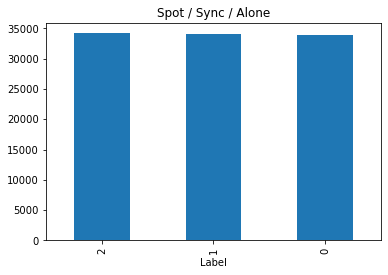

In [2785]:
DF['Label'].value_counts().plot.bar()
plt.title('Spot / Sync / Alone')
plt.xlabel('Label')
plt.show()

<AxesSubplot:>

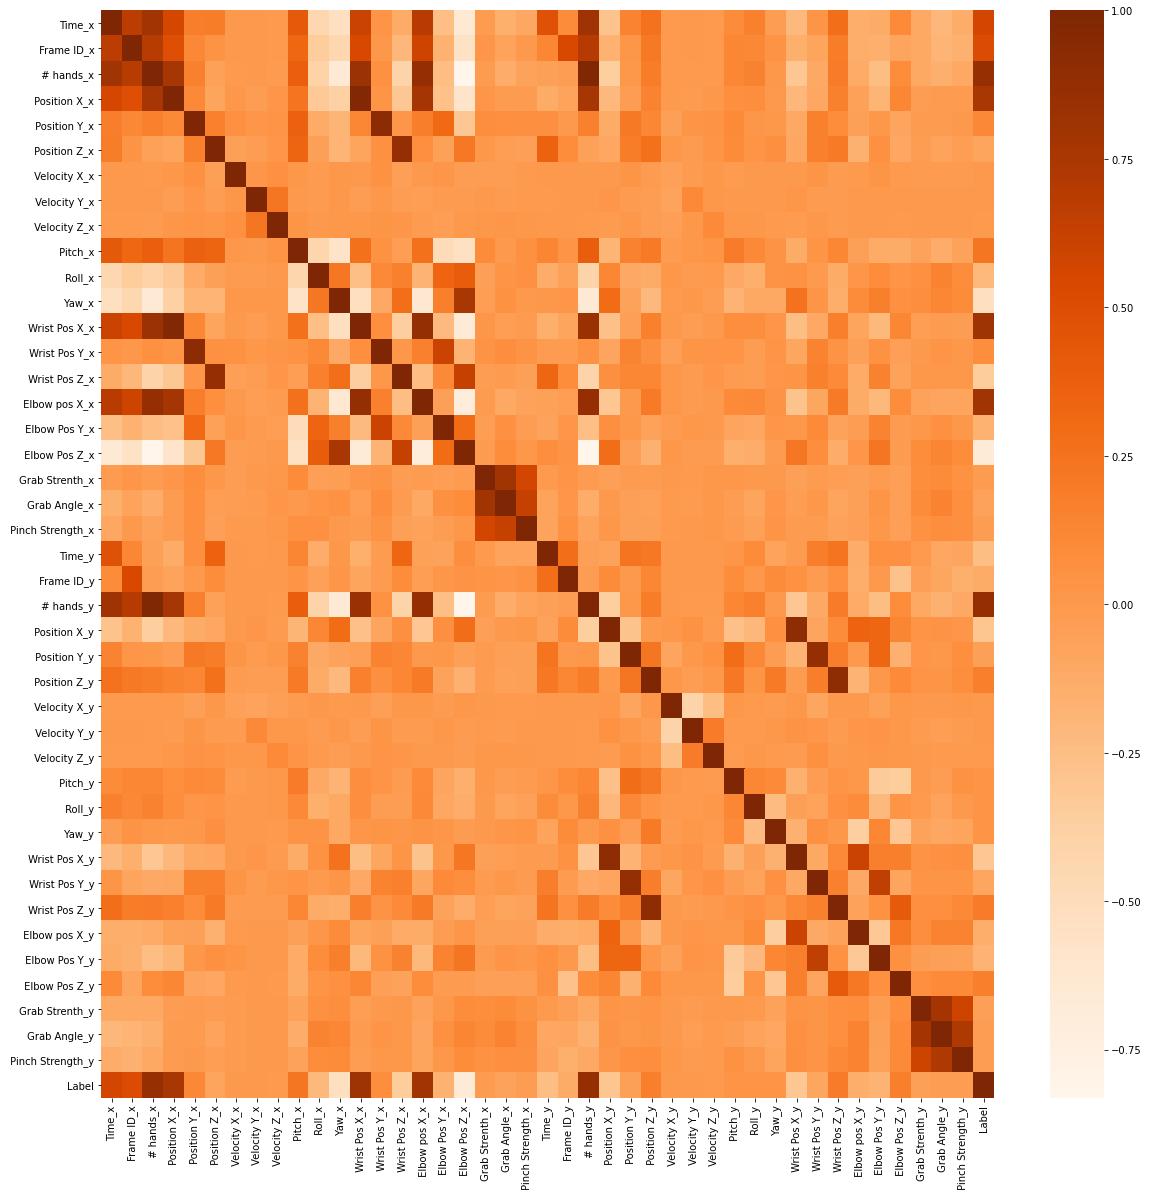

In [2804]:
plt.figure(figsize=(20,20))
sns.heatmap(DF.corr(), cmap = 'Oranges')

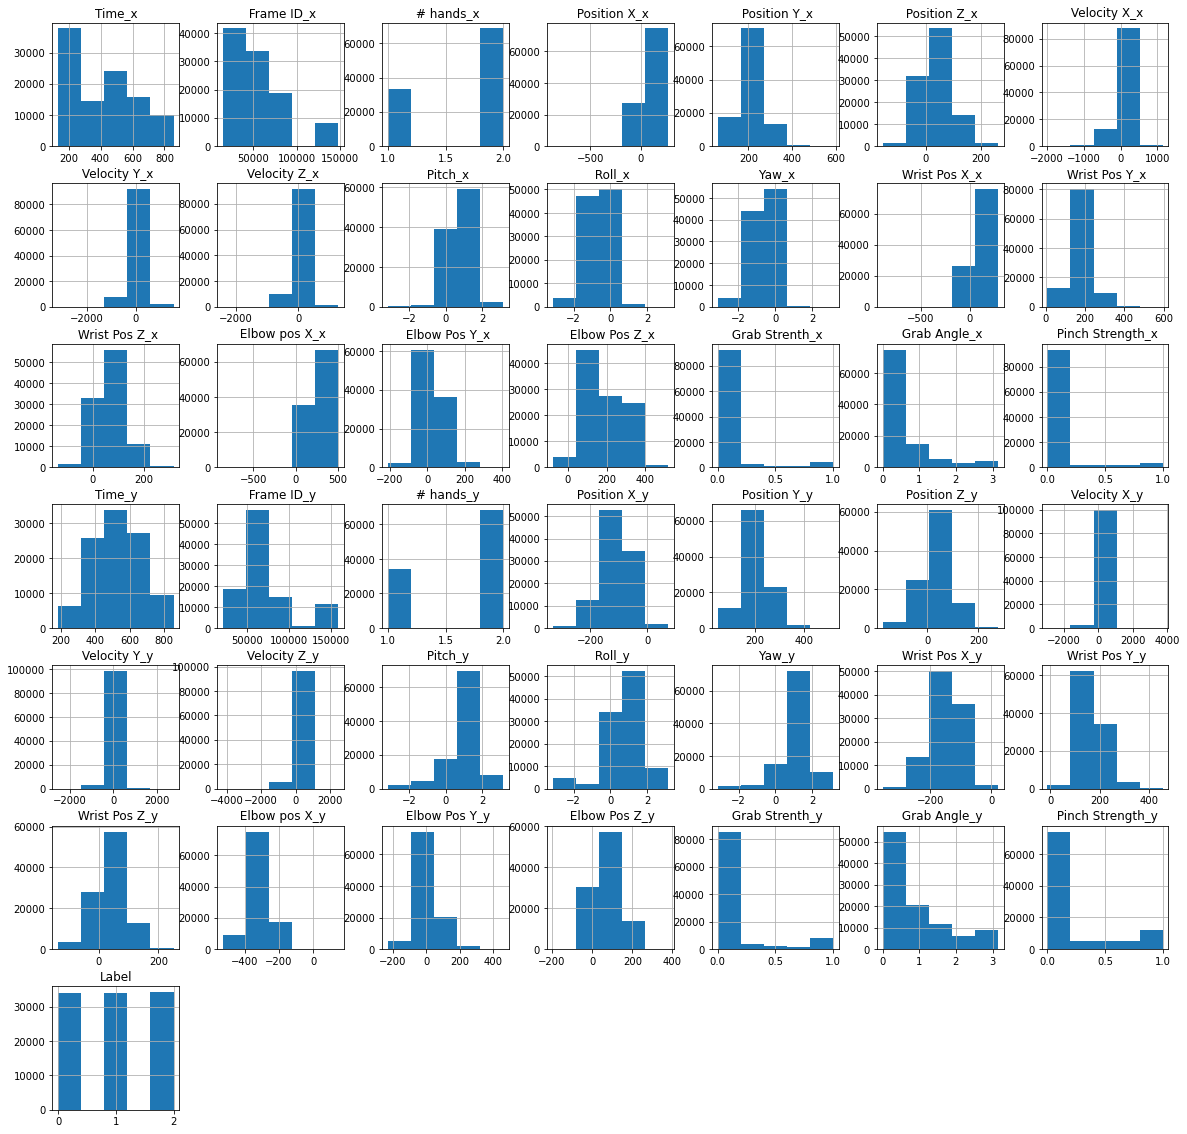

In [2803]:
DF.hist(bins=5, figsize=(20,20), axes)
plt.show()

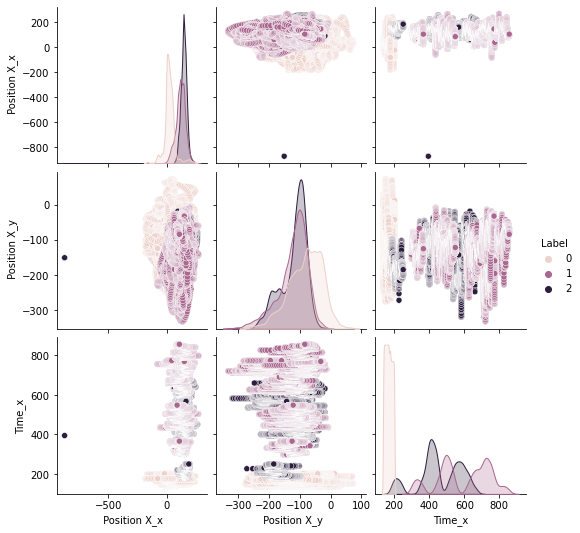

In [2802]:
sns.pairplot(DF,vars = [' Position X_x',' Position X_y','Time_x' ], hue='Label');

In [2630]:
DF['Label'].value_counts()

2    34182
1    34044
0    33941
Name: Label, dtype: int64

In [2631]:
DF[' # hands_x'].value_counts(), DF_Test[' # hands_x'].value_counts()

(2    68586
 1    33581
 Name:  # hands_x, dtype: int64,
 2    20260
 1     9845
 Name:  # hands_x, dtype: int64)

## Change the values to float

In [2632]:
DF.drop(DF[DF[' # hands_x'] == 1].index,inplace = True)
DF_Test.drop(DF[DF[' # hands_x'] == 1].index,inplace = True)
DF[' # hands_x'] = DF[' # hands_x'].astype(np.float)
DF[' Frame ID_x'] = DF[' Frame ID_x'].astype(np.float)
DF['Label'] = DF['Label'].astype(np.float)
DF[' Hand Type_y'] = 0.0
DF_Test[' # hands_x'] = DF_Test[' # hands_x'].astype(np.float)
DF_Test[' Frame ID_x'] = DF_Test[' Frame ID_x'].astype(np.float)
DF_Test['Label'] = DF_Test['Label'].astype(np.float)
DF_Test[' Hand Type_y'] = 0.0

## Take from the data 5th row 

In [2633]:
DF = DF.iloc[::5, :]
DF_Test = DF_Test.iloc[::5, :]
RefreshData(DF)
RefreshData(DF_Test)

In [2634]:
DF

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
0,142.5166,17119.0,2.0,50.14981,178.0161,52.791210,-296.017400,-240.199800,-99.481080,0.562146,...,-109.0570,201.0481,49.72544,-274.8570,14.24226,11.113140,1.000000,2.934518,0.000000,0.0
1,142.6000,17129.0,2.0,21.21379,167.0369,50.248230,-331.674000,-4.084924,-63.217940,0.525179,...,-119.4438,202.4176,48.69635,-302.9860,31.59961,16.909100,1.000000,3.141593,0.119746,0.0
2,151.8303,18192.0,2.0,33.80816,238.0094,62.897240,56.414760,-122.105100,-269.512800,0.223495,...,-124.9589,195.1527,33.20014,-294.5946,8.26706,19.544130,0.000000,1.935431,0.222311,0.0
3,151.9135,18202.0,2.0,36.82795,236.8113,53.170160,138.217400,72.390910,24.992300,0.250195,...,-124.3989,188.7146,31.57723,-266.3097,-18.44548,2.680526,0.009946,1.799965,0.593636,0.0
4,151.9971,18211.0,2.0,45.98056,227.4085,53.204080,44.185280,-188.846400,-30.014500,0.131164,...,-121.1439,179.5578,24.94929,-268.9785,-25.37995,19.080450,0.000000,0.627980,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13713,855.6636,67271.0,2.0,89.15375,176.7275,3.949953,0.339778,-0.073710,6.889667,0.289303,...,-106.2976,125.4548,30.17985,-326.8996,31.64537,127.859600,0.000000,0.153154,0.000000,1.0
13714,855.8308,67282.0,2.0,89.76945,179.0290,6.029916,13.961640,26.939900,23.405950,0.318540,...,-108.7883,127.1758,27.88128,-335.3457,40.44123,118.189900,0.000000,0.104868,0.000000,1.0
13715,855.9966,67290.0,2.0,92.72672,185.6738,9.417146,36.315940,72.122340,37.352950,0.403913,...,-113.9877,131.6802,31.17174,-344.2135,41.90628,108.266100,0.000000,0.000000,0.000000,1.0
13716,856.1633,67302.0,2.0,96.97344,203.6819,25.703670,28.056230,87.005400,138.416100,0.829770,...,-107.2952,126.9954,32.16775,-324.1952,28.55312,133.510300,0.000000,0.000000,0.000000,1.0


## Final Stage - Models Area

In [2635]:
X_train=DF.drop(columns='Label')
y_train=DF['Label']
X_test=DF_Test.drop(columns='Label')
y_test=DF_Test['Label']

In [2636]:
X_train.shape, y_train.shape , X_test.shape, y_test.shape

((13718, 43), (13718,), (6021, 43), (6021,))

In [2637]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### PCA

In [2638]:
PCA = pca(n_components = 0.95, random_state= 0, svd_solver='full')

X_Train_PCA = PCA.fit_transform(X_train)
X_test_PCA = PCA.transform(X_test)

print('Number of components is: {}'.format(PCA.n_components_))

Number of components is: 25


### XGBClassifier

In [2642]:
from sklearn.metrics import plot_confusion_matrix
xgb_clf=XGBClassifier()
xgb_clf.fit(X_Train_PCA,y_train)
y_pred = xgb_clf.predict(X_test_PCA)
xgb_score= xgb_clf.score(X_test_PCA, y_test)
print("Accuracy Score is ", xgb_score)

Accuracy Score is  0.7176548746055472


### RandomizedSearchCV on XGBClassifier to find the best estimator

In [2650]:
from sklearn.model_selection import RandomizedSearchCV
start = time.time()
param_grid = {'max_depth':[3,6,9],'num_class': [3], 'learning_rate':[0.001,0.005,0.001, 0.03, 0.1,0.2],'n_estimators':[200,500,800,1000],'colsample_bytree':[0.3,0.7]}
xgb_c = XGBClassifier(objective='multi:softmax',n_jobs=-1,gamma=0,colsample_bytree=0.8)

XGBGridsearch = RandomizedSearchCV(estimator=xgb_c,param_distributions=param_grid,verbose=3,scoring='accuracy',n_jobs=-1,cv=5,n_iter=15)
XGBGridsearch.fit(X_Train_PCA,y_train)
time.time()-start

Fitting 5 folds for each of 15 candidates, totalling 75 fits


896.8225073814392

In [2651]:
XGBGridsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [2652]:
xgb_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=800, n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_clf.fit(X_Train_PCA,y_train)
y_pred = xgb_clf.predict(X_test_PCA)
xgb_score= xgb_clf.score(X_test_PCA, y_test)
print("Accuracy Score is ", xgb_score)

Accuracy Score is  0.7457233017771134


### RandomForestClassifier

In [2646]:
#random forest classifier model.
start = time.time()
RFC_PCA = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=12,n_jobs=-1)
RFC_PCA.fit(X_Train_PCA, y_train)
y_predict = RFC_PCA.predict(X_test_PCA)
print('RandomForestClassifier Accuracy is: {}'.format(RFC_PCA.score(X_test_PCA,y_test)))
time.time()-start

RandomForestClassifier Accuracy is: 0.6738083374854675


12.004902362823486

### RandomizedSearchCV on RandomForestClassifier to find the best estimator

In [2647]:
start = time.time()
forest_params = {'n_estimators':[100,200,400,500,700,1000,2000], 'max_depth':[None,30,100],'max_features':['auto','sqrt','log2'],'random_state':[0]}
forest_grid_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),forest_params,cv=3,scoring='accuracy',return_train_score=True,random_state=0)
forest_grid_search.fit(X_Train_PCA,y_train)
time.time()-start

263.1356589794159

In [2648]:
forest_grid_search.best_estimator_

RandomForestClassifier(max_depth=100, max_features='log2', n_estimators=2000,
                       n_jobs=-1, random_state=0)

In [2649]:
#random forest classifier model.
start = time.time()
RFC_PCA = RandomForestClassifier(max_depth=100, max_features='log2', n_estimators=2000,n_jobs=-1, random_state=0)
RFC_PCA.fit(X_Train_PCA, y_train)
y_predict = RFC_PCA.predict(X_test_PCA)
print('RandomForestClassifier Accuracy is: {}'.format(RFC_PCA.score(X_test_PCA,y_test)))
time.time()-start

RandomForestClassifier Accuracy is: 0.7568510214250125


41.45633244514465

### KNeighborsClassifier

In [2669]:
start = time.time()
K = list(range(1, 11))
scores = []
for n in K:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_Train_PCA, y_train)
    y_pred = knn.predict(X_Train_PCA)
    scores.append(knn.score(X_test_PCA,y_test))
    print('KNeighborsClassifier: n = {} , Accuracy is: {}'.format(n,knn.score(X_test_PCA,y_test)))
time.time()-start

KNeighborsClassifier: n = 1 , Accuracy is: 0.8334163760172729
KNeighborsClassifier: n = 2 , Accuracy is: 0.8159774123899685
KNeighborsClassifier: n = 3 , Accuracy is: 0.8347450589603056
KNeighborsClassifier: n = 4 , Accuracy is: 0.8232851685766484
KNeighborsClassifier: n = 5 , Accuracy is: 0.8330842052815147
KNeighborsClassifier: n = 6 , Accuracy is: 0.824447766151802
KNeighborsClassifier: n = 7 , Accuracy is: 0.833582461385152
KNeighborsClassifier: n = 8 , Accuracy is: 0.8256103637269556
KNeighborsClassifier: n = 9 , Accuracy is: 0.8327520345457565
KNeighborsClassifier: n = 10 , Accuracy is: 0.8242816807839229


68.10500049591064

### KNeighborsClassifier Plot - to check the best Neightbors value

Text(0, 0.5, 'Accuracy')

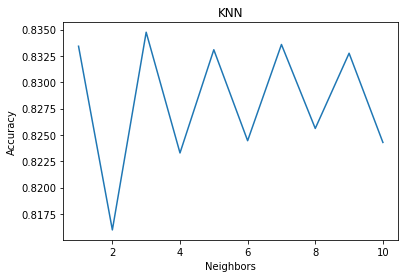

In [2670]:
plt.plot(K, scores)
plt.title("KNN")
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')

In [2672]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_Train_PCA, y_train)
y_pred = knn.predict(X_Train_PCA)
print('KNeighborsClassifier: n = {} , Accuracy is: {}'.format(3,knn.score(X_test_PCA,y_test)))

KNeighborsClassifier: n = 3 , Accuracy is: 0.8347450589603056


### StackingClassifier with the models

In [2673]:
start = time.time()
estimators = [('RFC',RFC_PCA),('XGB', xgb_clf),('KNN', knn)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(X_Train_PCA,y_train)
time.time() - start

309.69882678985596

In [2674]:
print('StackingClassifier Accuracy is: {}'.format(clf.score(X_test_PCA,y_test)))

StackingClassifier Accuracy is: 0.7752864972595914


### BaggingClassifier on the best score model give to us.

In [2677]:
start = time.time()
Bagging = BaggingClassifier(RFC_PCA)
Bagging.fit(X_Train_PCA, y_train)
print('BaggingClassifier Accuracy is: {}'.format(Bagging.score(X_test_PCA,y_test)))
time.time() - start

BaggingClassifier Accuracy is: 0.7571831921607707


1194.7092847824097

### GridSearchCV

In [2678]:
start = time.time()
params = {"base_estimator__n_estimators" : [1000,2000,3000]}
GridSearch = GridSearchCV(Bagging,params)
GridSearch.fit(X_Train_PCA,y_train)
print('GridSearch best Accuracy is: {}'.format(GridSearch.best_params_))
time.time() - start

GridSearch best Accuracy is: {'base_estimator__n_estimators': 2000}


7790.284744024277

In [2679]:
print('GridSearch best Accuracy is: {}'.format(GridSearch.best_score_))

GridSearch best Accuracy is: 0.8491088633776516


### VotingClassifier 

In [2683]:
start = time.time()
knn_clf = KNeighborsClassifier(n_neighbors=3)
dec_clf = DecisionTreeClassifier()
Voting_S = VotingClassifier(estimators=[ ('rf', RFC_PCA), ('xgb', xgb_clf), ('knn', knn_clf), ('dec', dec_clf), ('bg', GridSearch)],voting='soft',n_jobs=-1)
Voting_S.fit(X_Train_PCA, y_train)
time.time() - start

6228.636059999466

In [2684]:
start = time.time()
SC = cross_val_score(Voting_S, X_test_PCA, y_test, cv=5, n_jobs=-1).mean()
print('Cross Val best Accuracy is: {}'.format(SC))
time.time() - start

Cross Val best Accuracy is: 0.891216415544313


5076.575346708298

## The final model on the test (dataset) gives us Accuracy of 0.8912 with 25 components with StandardScaler